In [2]:
import pandas as pd
import requests

from igraph import Graph, plot

## Setting up dataframe

In [3]:
col_names = [
        "type", "sflow_agent_address", "inputPort", "outputPort", "src_MAC",
        "dst_MAC", "ethernet_type", "in_vlan", "out_vlan", "src_IP", "dst_IP",
        "IP_protocol", "ip_tos", "ip_ttl", "src_transport_port", "dst_transport_port",
        "tcp_flags", "packet_size", "IP_size", "sampling_rate"
    ]

df = pd.read_csv("sample.csv")

# remove last column because it's all NaN for some reason
df = df.iloc[:,:-1]
df.columns = col_names

In [4]:
# kill all rows with type == "CNTR" because they're non-conforming to our submission
df.drop(df.index[df["type"] == "CNTR"], inplace=True)
df.head()

,type,sflow_agent_address,inputPort,outputPort,src_MAC,dst_MAC,ethernet_type,in_vlan,out_vlan,src_IP,dst_IP,IP_protocol,ip_tos,ip_ttl,src_transport_port,dst_transport_port,tcp_flags,packet_size,IP_size,sampling_rate
0,FLOW,aa.aa.aa.aa,258,20,204e71cf1b0f,002438aa0a00,0x0800,3012.0,3012,152.3.219.19,198.71.44.98,50,0x00,245,0.0,0,0x00,1518,1496,2048
1,FLOW,aa.aa.aa.aa,258,20,204e71cf1b0f,002438aa0a00,0x0800,3012.0,3012,152.3.219.19,198.71.44.98,50,0x00,245,0.0,0,0x00,1518,1496,2048
2,FLOW,aa.aa.aa.aa,258,20,204e71cf1b0f,002438aa0a00,0x0800,3012.0,3012,152.3.219.19,198.71.44.98,50,0x00,245,0.0,0,0x00,1518,1496,2048
3,FLOW,aa.aa.aa.aa,258,20,204e71cf1b0f,002438aa0a00,0x0800,3012.0,3012,152.3.219.19,198.71.44.98,50,0x00,245,0.0,0,0x00,1518,1496,2048
4,FLOW,aa.aa.aa.aa,258,20,204e71cf1b0f,002438aa0a00,0x0800,3012.0,3012,152.3.219.19,198.71.44.98,50,0x00,245,0.0,0,0x00,1518,1496,2048


## 4A. Top Talkers and Listeners

In [5]:
# top 5 talkers i assume is the top 5 occurences of "src_IP"
top_talkers = df["src_IP"].value_counts().nlargest(5)

for ip in top_talkers.index:
    res = requests.get(f"http://ip-api.com/json/{ip}")
    res_json = res.json()
    org = res_json["org"]
    packet_count = top_talkers[ip]
    
    print(f"IP address: {ip}\t# of packets: {packet_count}\tOrganisation: {org}")

IP address: 152.3.219.19	# of packets: 125	Organisation: Duke University
IP address: 207.241.228.157	# of packets: 66	Organisation: Internet Archive
IP address: 130.14.250.13	# of packets: 63	Organisation: National Library of Medicine
IP address: 193.62.192.8	# of packets: 46	Organisation: European Bioinformatics Institute
IP address: 192.122.131.36	# of packets: 40	Organisation: A*STAR


In [6]:
# top 5 talkers i assume is the top 5 occurences of "dst_IP"
top_listeners = df["dst_IP"].value_counts().nlargest(5)

for ip in top_listeners.index:
    res = requests.get(f"http://ip-api.com/json/{ip}")
    res_json = res.json()
    org = res_json["org"]
    packet_count = top_listeners[ip]
    
    print(f"IP address: {ip}\t# of packets: {packet_count}\tOrganisation: {org}")

IP address: 198.71.44.98	# of packets: 125	Organisation: Internet2
IP address: 103.37.198.100	# of packets: 98	Organisation: A*STAR
IP address: 210.48.222.9	# of packets: 66	Organisation: International Islamic University Of Malaysia
IP address: 137.132.228.15	# of packets: 50	Organisation: National University of Singapore
IP address: 202.21.159.244	# of packets: 38	Organisation: Rpnet


# 4B Transport Protocol

In [7]:
# TCP = 6, UDP = 17
protocols = df["IP_protocol"].value_counts()

tcp_count = protocols[6]
udp_count = protocols[17]

print(f"TCP packet count: {tcp_count}\nUDP packet count: {udp_count}")

TCP packet count: 879
UDP packet count: 135


# 4C Applications Protocol

In [8]:
# go and google what each port represents
top_applications = df["dst_transport_port"].value_counts().nlargest(5)
print(top_applications)

443      234
56152     82
0         80
43930     45
80        37
Name: dst_transport_port, dtype: int64


# 4D Traffic

In [9]:
# total traffic I assume is sum of all packet sizes
total_packet_size = df["packet_size"].sum() / 1024
print(f"Total traffic: {total_packet_size: .3f} MB")

Total traffic:  1077.241 MB


# 4E Additional Analysis

### Displaying top 5 communication pairs (sender->receiver)

In [10]:
top_freq = df.groupby(["src_IP", "dst_IP"])\
             .size()\
             .sort_values(ascending=False)\
             .nlargest(5)

for src_ip, dst_ip in top_freq.index:
    count = top_freq[(src_ip, dst_ip)]
    
    res_src = requests.get(f"http://ip-api.com/json/{src_ip}")
    org_src = res_src.json()["org"] if res_src.status_code == 200 else "No response from server"
    
    res_dst = requests.get(f"http://ip-api.com/json/{dst_ip}")
    org_dst = res_src.json()["org"] if res_dst.status_code == 200 else "No response from server"
    
    print(f"Source: {src_ip:15} ({org_src+')':35}\tDestination: {dst_ip:15} ({org_dst+')':35}\tPacket count: {count}")

Source: 152.3.219.19    (Duke University)                   	Destination: 198.71.44.98    (Duke University)                   	Packet count: 125
Source: 207.241.228.157 (Internet Archive)                  	Destination: 210.48.222.9    (Internet Archive)                  	Packet count: 66
Source: 130.14.250.13   (National Library of Medicine)      	Destination: 103.37.198.100  (National Library of Medicine)      	Packet count: 63
Source: 193.62.192.8    (European Bioinformatics Institute) 	Destination: 137.132.228.15  (European Bioinformatics Institute) 	Packet count: 46
Source: 130.14.250.11   (National Library of Medicine)      	Destination: 103.37.198.100  (National Library of Medicine)      	Packet count: 35


### Graphical visualisation of the network monitoring

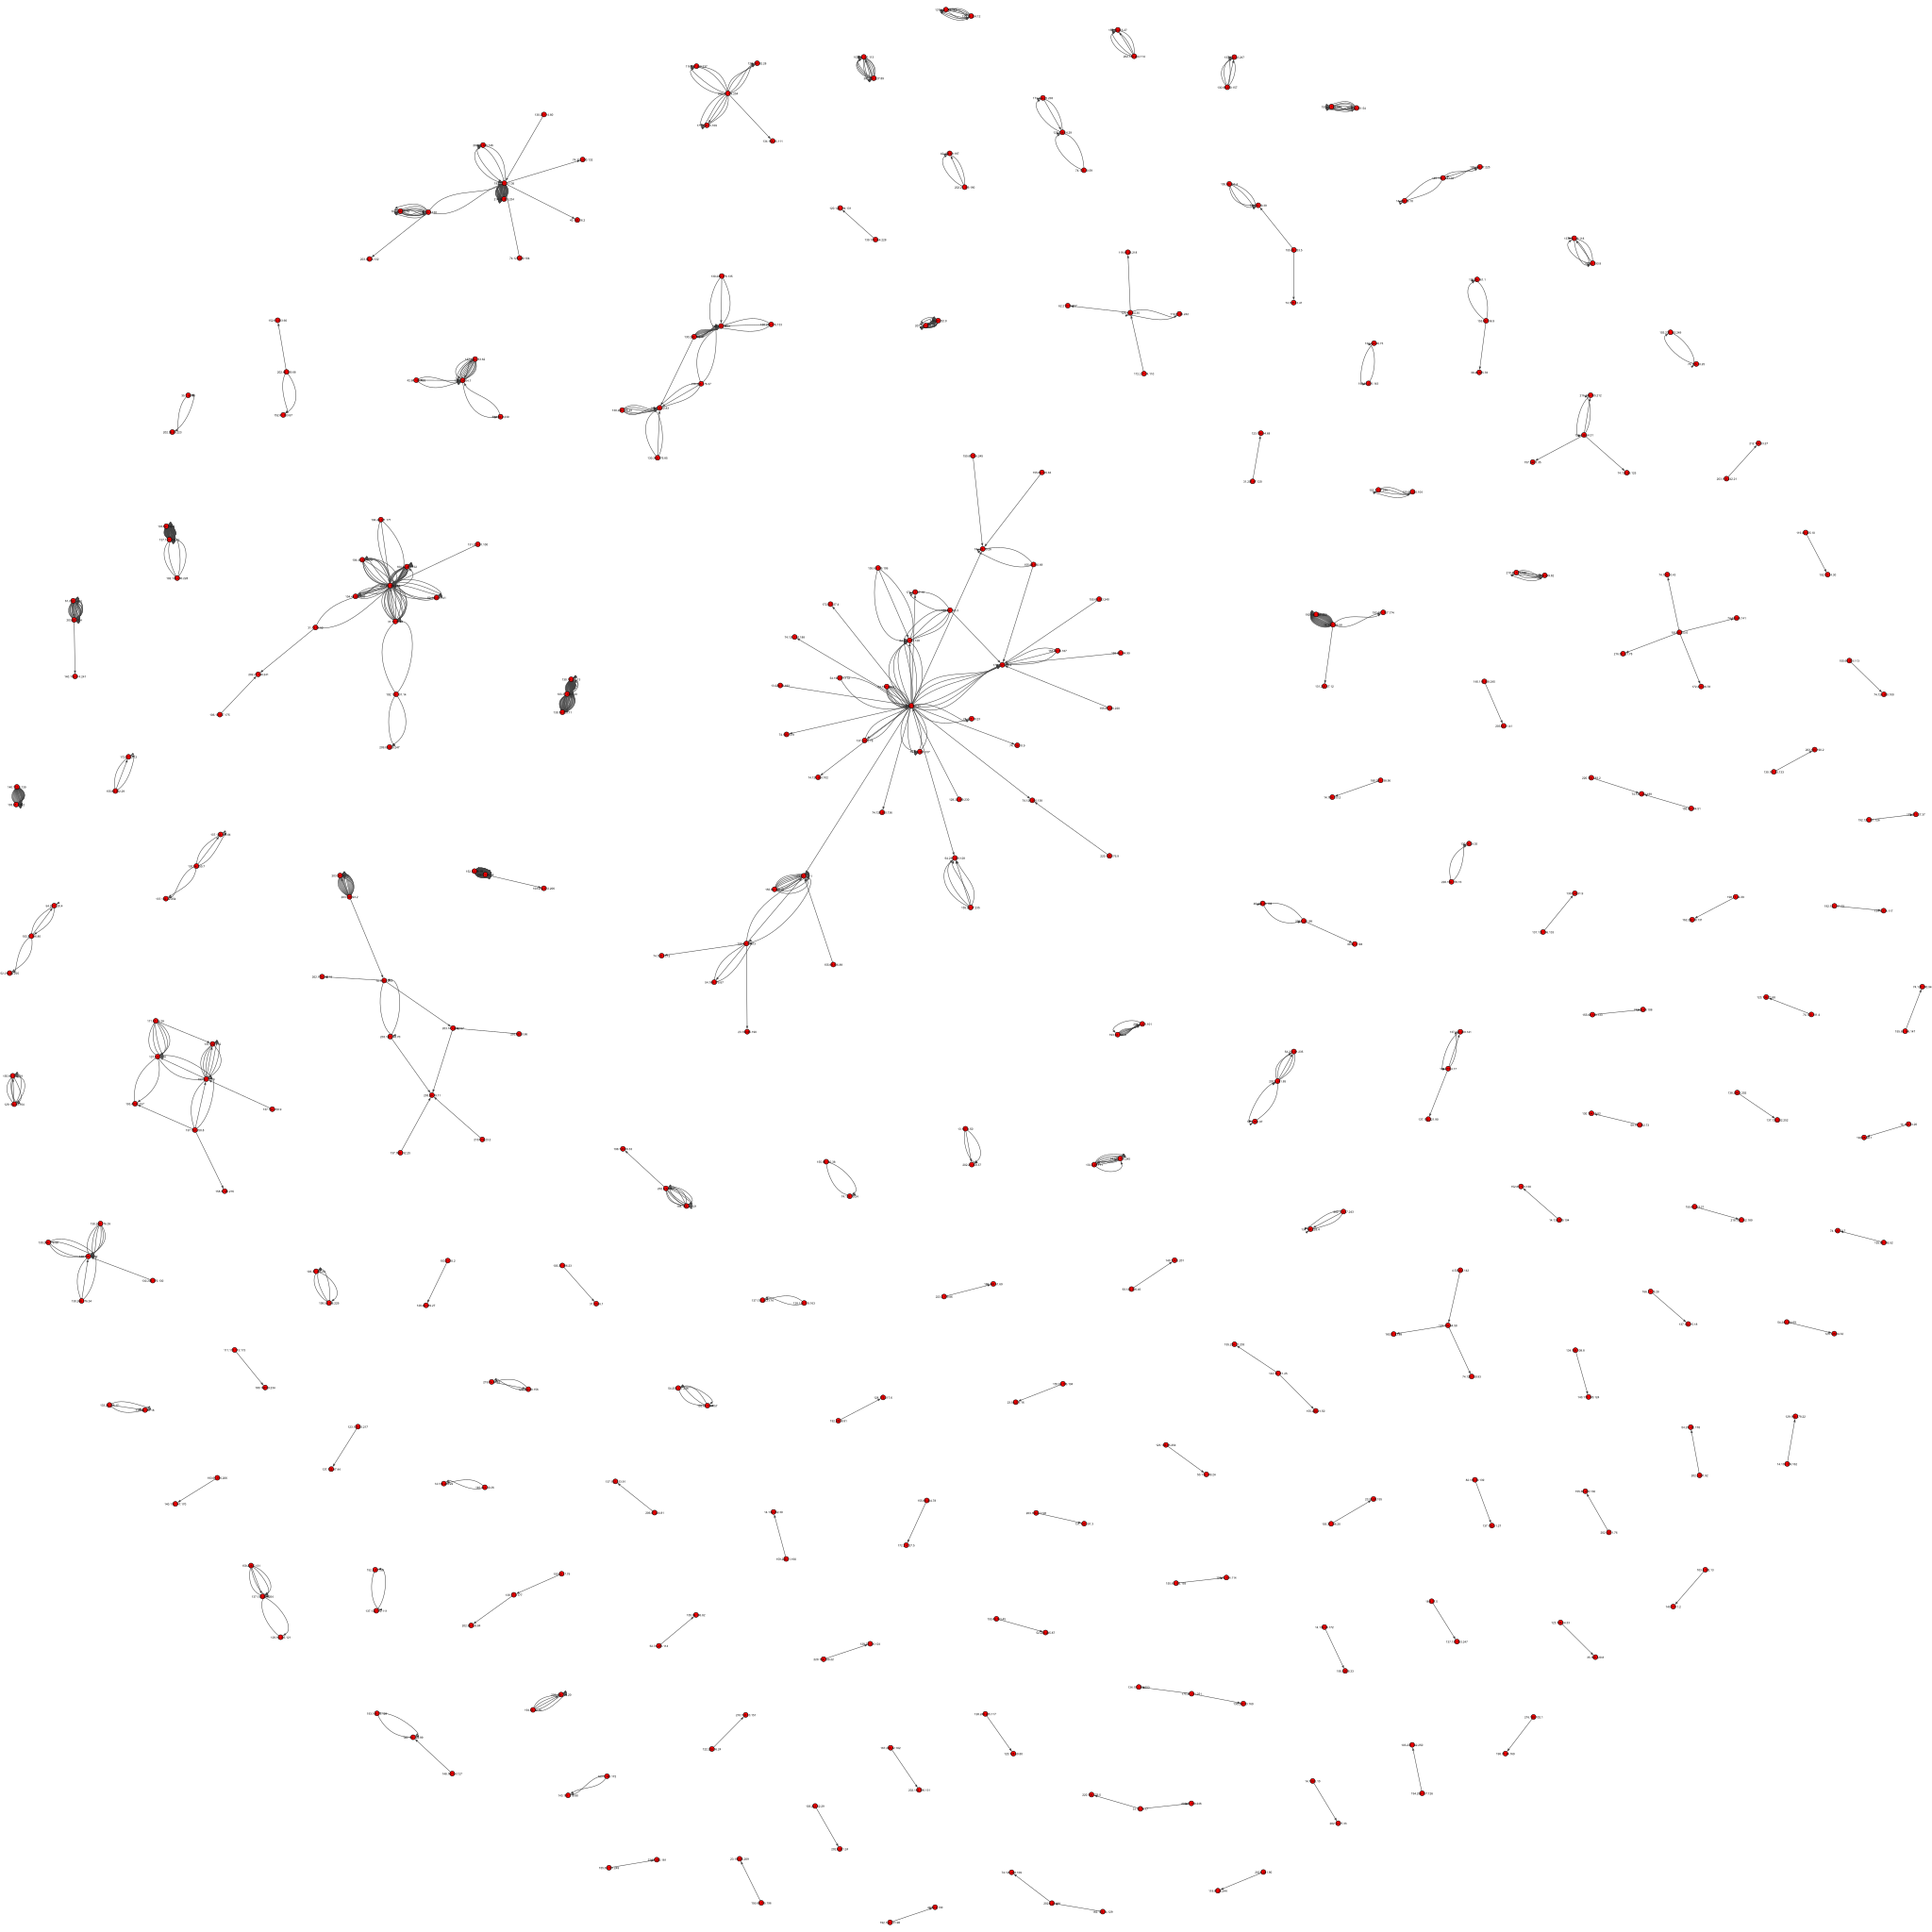

In [11]:
# decided to just use the IPs and not the organisation name since it would just result in a bunch of 429 responses.
g = Graph.DataFrame(df[["src_IP", "dst_IP"]])

g.vs["size"] = 6
g.vs["label_size"] = 3
g.vs["label"] = g.vs["name"]

g.es["width"] = 1
g.es["arrow_size"] = 0.2

# simple look
plot(g, "compact.svg", bbox=(500, 500))

# closer look at the edges
g.vs["size"] = 10
g.vs["label_size"] = 6
g.es["arrow_size"] = 0.5
plot(g, "spacious.svg", bbox=(4000, 4000))